# Build Python Library for Homomorphic Encryption

In this demo, we use the python version of SEAL (Simple Encryption Arithmetic Library) which is developed by Microsoft. Python version is from https://github.com/Huelse/SEAL-Python.

In [ ]:
!git clone https://github.com/Huelse/SEAL-Python.git
%cd SEAL-Python
!pip3 install numpy pybind11
!git submodule update --init --recursive
%cd SEAL
!cmake -S . -B build -DSEAL_USE_MSGSL=OFF -DSEAL_USE_ZLIB=OFF
!cmake --build build
%cd ..
!python3 setup.py build_ext -i

Cloning into 'SEAL-Python'...
remote: Enumerating objects: 1628, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 1628 (delta 176), reused 191 (delta 162), pack-reused 1376
Receiving objects: 100% (1628/1628), 8.68 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (882/882), done.
/content/SEAL-Python
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 6.6 MB/s eta 0:00:00
Submodule 'SEAL' (https://github.com/microsoft/SEAL.git) registered for path 'SEAL'
Submodule 'pybind11' (https://github.com/pybind/pybind11.git) registered for path 'pybind11'
Cloning into '/content/SEAL-Python/SEAL'...
Cloning into '/content/SEAL-Python/pybind11'...
Submodule path 'SEAL': checked out '206648d0e4634e5c61dcf9370676630268290b59'
Submodule path 'pybind11': checked out 'be97c5a98b4b252c524566f508b5c79410d118c6'
/content/SEAL-Python/SEAL
-- Build type (CMAKE_BUILD_TYPE): Release
-- The CXX compiler identification is GNU 9.4.0
-- Th

In [ ]:
%cd /content
!git clone https://github.com/KyoohyungHan/DemoForEyesOffDataSummit.git

/content
Cloning into 'DemoForEyesOffDataSummit'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), 93.94 KiB | 1.81 MiB/s, done.


# Load Modules

In [ ]:
%cd /content/SEAL-Python

import sys
import time
import math
import numpy as np
from seal import *

/content/SEAL-Python


# Homomorphic Encryption Parameters
For encrypted inference, this demo uses the CKKS scheme which supports real number plaintext. HE parameters are as follows:

* Polynomial Degree : 16384
* Coefficient Modulus : [60, 40, 40, 40, 60]
* Scale Factor (for encoding) : 2^40



In [ ]:
parms = EncryptionParameters(scheme_type.ckks)
poly_modulus_degree = 8192
parms.set_poly_modulus_degree(poly_modulus_degree)
parms.set_coeff_modulus(CoeffModulus.Create(poly_modulus_degree, [60, 40, 40, 60]))
scale = 2.0**40
context = SEALContext(parms)

# Various Classes for HE operations

In [ ]:
ckks_encoder = CKKSEncoder(context)
slot_count = ckks_encoder.slot_count()

keygen = KeyGenerator(context)
public_key = keygen.create_public_key()
secret_key = keygen.secret_key()
galois_keys = keygen.create_galois_keys()

encryptor = Encryptor(context, public_key)
evaluator = Evaluator(context)
decryptor = Decryptor(context, secret_key)

# Encrypt Single MNIST input to Single Ciphertext

First, we need to define how to encrypt MNIST inputs to HE ciphertexts. 28 by 28 pixel image can be represented as real number vector with length 784 (with flatten). In our HE parameter, up to 4096 real numbers can be encrypted in a ciphertext. So we pad zero numbers to this input vector.

```
[a1, a2, ..., a784] -> [a1, a2, ..., a784, 0, 0, ..., 0]
```

## Optimization

At matrix multiplication, inner product is key operation. In addition, a vector is encrypted in a single ciphertext. As we can do rotation in encrypted state, we can do summation of elements in this vector using log(n) number of rotations (for length of vector n).

In [ ]:
def encode_with_padding(x, s):
  plain = [0.0] * slot_count
  for i in range(len(x)):
    plain[i] = x[i]
  return ckks_encoder.encode(plain, s)

def encrypt_with_padding(x, s):
  encoded = encode_with_padding(x, s)
  return encryptor.encrypt(encoded)

def summation_of_first_1024_slots(ciphertext):
  tmp = ciphertext
  for i in range(10):
    rotated = evaluator.rotate_vector(tmp, 2**i, galois_keys)
    tmp = evaluator.add(tmp, rotated)
  return tmp

# Load MNIST model

Prebuild MNIST model for demo. This model is simple model with 1 dense layer and custom activation function x^3. The accuracy of this model is about 90%.

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/DemoForEyesOffDataSummit/mnist')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


# Encode Model Coefficients

For encrypted inference, we need to encode model weights to polynomials.

In [ ]:
coeff = []
w = model.weights[0].numpy()
for i in range(10):
  ith_coeff = [0.0] * 784
  for j in range(784):
    ith_coeff[j] = w[j][i]
  coeff.append(ith_coeff)

encoded_coeff = []
for i in range(10):
  encoded_coeff.append(encode_with_padding(coeff[i], scale))

# Define Functions for Encrypted Inference

In [ ]:
w0 = model.weights[1].numpy()

def encrypted_inference(encrypted_input):
  encrypted_result = []
  for i in range(10):
    e1 = evaluator.multiply_plain(encrypted_input, encoded_coeff[i])
    evaluator.rescale_to_next_inplace(e1)
    e2 = summation_of_first_1024_slots(e1)
    new_scale = e2.scale()
    encoded_coeff0 = encode_with_padding([w0[i]], new_scale)
    evaluator.mod_switch_to_next_inplace(encoded_coeff0)
    e2 = evaluator.add_plain(e2, encoded_coeff0)
    encrypted_result.append(e2)
  return encrypted_result

def decrypt_result(encrypted_result):
  result = []
  for i in range(10):
    decoded = ckks_encoder.decode(decryptor.decrypt(encrypted_result[i]))
    result.append(decoded[0])
  return np.argmax(result)

# Load Test Data

11490434/11490434 [==============================] - 0s 0us/step


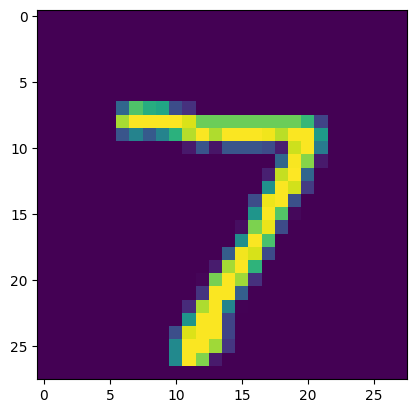

In [ ]:
# Load data for test
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Show data
from matplotlib import pyplot as plt
plt.imshow(x_test[0])

# Step1. Encrypt Input Image

In [ ]:
msg = x_test[0] / 255.0
msg = msg.flatten()
encrypted_input = encrypt_with_padding(msg, scale)

# Step2. Run Encrypted Inference

In [ ]:
encrypted_result = encrypted_inference(encrypted_input)

# Step3. Decrypt Encrypted Result and Compare

In [ ]:
result = decrypt_result(encrypted_result)

# Result of encrypted inference
print(result)

# Label
print(y_test[0])

7
7


# Compute the accuracy

In [ ]:
n_test_imgs = 200
n_images_between_prints = 20

n_correct_predictions = 0
for i in range(n_test_imgs):
  if (i % n_images_between_prints) == 0 :
    print(str(i) + ' / ' + str(n_test_imgs))
  index = np.random.randint(0, len(x_test))
  msg = x_test[index] / 255.0
  msg = msg.flatten()
  encrypted_input = encrypt_with_padding(msg, scale)
  encrypted_result = encrypted_inference(encrypted_input)
  result = decrypt_result(encrypted_result)
  n_correct_predictions += (result == y_test[index])

p = n_correct_predictions / n_test_imgs
print('Estimated accuracy: ' + str(p) + '±'
      + '%.2e' % (np.sqrt(p*(1-p)/n_test_imgs) + 1 / n_test_imgs))

0 / 200
20 / 200
40 / 200
60 / 200
80 / 200
100 / 200
120 / 200
140 / 200
160 / 200
180 / 200
Estimated accuracy: 0.905±2.57e-02
